In [17]:
import json
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [18]:
FILE_PATH = "../../data/jackal_irl_one_spin"
with open(os.path.join(FILE_PATH, "transforms.json")) as f:
    data = json.load(f)

In [19]:
def select_physical_solution(R1, R2, t1, t2, K1, K2, pts1, pts2):
    # Triangulate points for each combination of R and t
    P1 = np.hstack((np.eye(3), np.zeros((3, 1))))
    P1 = K1 @ P1

    def triangulate_and_check(R, t):
        P2 = np.hstack((R, t.reshape(3, 1)))
        P2 = K2 @ P2

        points_4d_hom = cv2.triangulatePoints(P1, P2, pts1.T, pts2.T)
        points_3d = points_4d_hom[:3] / points_4d_hom[3]

        return points_3d

    def is_in_front(points_3d):
        return np.mean(points_3d[2] > 0)

    solutions = [(R1, t1), (R1, t2), (R2, t1), (R2, t2)]
    max_index = 0
    max_val = 0
    for i in range(4):
        R, t = solutions[i]
        points_3d = triangulate_and_check(R, t)
        if is_in_front(points_3d) > max_val:
            max_val = is_in_front(points_3d)
            max_index = i
    print(max_val)
    return solutions[max_index]
    raise ValueError("No physically realistic solution found")

In [20]:
data["frames"][0]["transform_matrix"] = np.eye(4).tolist()
camera_matrix = [[
    data["focal_length"]*1e-3, 0, data["cx"],
    0, data["focal_length"]*1e-3, data["cy"],
    0, 0, 1
]]
camera_matrix = np.array(camera_matrix).reshape(3, 3)

for frame in range(len(data["frames"])-1):
    print(frame)
    IMG_1 = frame
    IMG_2 = frame + 1

    # Open Images and mask
    img1 = cv2.imread(os.path.join(FILE_PATH, data["frames"][IMG_1]["file_path"]))
    img2 = cv2.imread(os.path.join(FILE_PATH, data["frames"][IMG_2]["file_path"]))
    mask1 = cv2.imread(os.path.join(FILE_PATH, data["frames"][IMG_1]["mask_path"]), cv2.IMREAD_GRAYSCALE)
    mask2 = cv2.imread(os.path.join(FILE_PATH, data["frames"][IMG_2]["mask_path"]), cv2.IMREAD_GRAYSCALE)

    #Find SIFT featues in mask region
    sift = cv2.SIFT_create()

    kp1, des1 = sift.detectAndCompute(img1, mask1)
    kp2, des2 = sift.detectAndCompute(img2, mask2)

    # Match features
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)

    # Apply ratio test
    good = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good.append(m)

    # Estimate fundmental matrix
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1, 2)
    F, mask = cv2.findFundamentalMat(src_pts, dst_pts, cv2.FM_RANSAC)

    # Find Essential Matrix
    E = np.dot(camera_matrix.T, np.dot(F, camera_matrix))
    
    R1, R2, t = cv2.decomposeEssentialMat(E)

    best_R, best_t = select_physical_solution(R1, R2, t, -t, camera_matrix, camera_matrix, src_pts, dst_pts)

    relative_pose = np.eye(4)
    relative_pose[:3, :3] = best_R
    relative_pose[:3, 3] = best_t.squeeze()
    data["frames"][IMG_2]["transform_matrix"] = (relative_pose @ data["frames"][IMG_1]["transform_matrix"]).tolist()

0
1.0
1
1.0
2
1.0
3
0.5
4
1.0
5
1.0
6
1.0
7
1.0
8
1.0
9
1.0
10
1.0
11
1.0
12
1.0
13
1.0
14
1.0
15
1.0
16
1.0
17
1.0
18
1.0
19
1.0
20
1.0
21
1.0
22
1.0
23
1.0
24
1.0
25
1.0
26
1.0
27
1.0
28
1.0
29
1.0
30
1.0
31
1.0
32
0.8076923076923077
33
1.0
34
1.0
35
1.0
36
1.0
37
1.0
38
1.0
39
1.0
40
1.0
41
1.0
42
1.0
43
1.0
44
1.0
45
1.0
46
1.0
47
1.0
48
1.0
49
1.0
50
1.0
51
1.0
52
1.0
53
1.0
54
1.0
55
1.0
56
1.0
57
1.0
58
1.0
59
1.0
60
1.0
61
1.0
62
1.0
63
1.0
64
1.0
65
1.0
66
1.0
67
1.0
68
1.0
69
1.0
70
1.0
71
1.0
72
1.0
73
1.0
74
1.0
75
1.0
76
1.0
77
1.0
78
1.0
79
1.0
80
1.0
81
1.0
82
1.0
83
1.0
84
1.0
85
1.0
86
1.0
87
1.0
88
1.0
89
1.0
90
1.0
91
1.0
92
1.0
93
1.0
94
1.0
95
1.0
96
1.0
97
1.0
98
1.0
99
1.0
100
1.0
101
1.0
102
1.0
103
1.0
104
1.0
105
1.0
106
1.0
107
1.0
108
1.0
109
1.0
110
1.0
111
1.0
112
1.0
113
1.0
114
1.0
115
1.0
116
1.0
117
1.0
118
1.0
119
1.0
120
1.0
121
1.0
122
1.0
123
1.0
124
1.0
125
1.0
126
1.0
127
1.0
128
1.0
129
1.0


In [21]:
#Save data
with open(os.path.join(FILE_PATH, "transforms.json"), "w") as f:
    json.dump(data, f, indent=4)

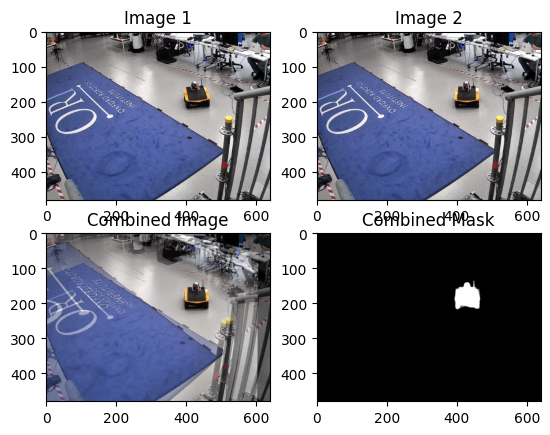

In [22]:
# Find Homography
H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

# Warp images
img1_warped = cv2.warpPerspective(img1, H, (img2.shape[1], img2.shape[0]))
mask1_warped = cv2.warpPerspective(mask1, H, (mask2.shape[1], mask2.shape[0]))

# Combine images
img_combined = cv2.addWeighted(img1_warped, 0.5, img2, 0.5, 0)
mask_combined = cv2.addWeighted(mask1_warped, 0.5, mask2, 0.5, 0)

# Plot
plt.figure()
plt.subplot(221)
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
plt.title("Image 1")
plt.subplot(222)
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
plt.title("Image 2")
plt.subplot(223)
plt.imshow(cv2.cvtColor(img_combined, cv2.COLOR_BGR2RGB))
plt.title("Combined Image")
plt.subplot(224)
plt.imshow(mask_combined, cmap="gray")
plt.title("Combined Mask")
plt.show()

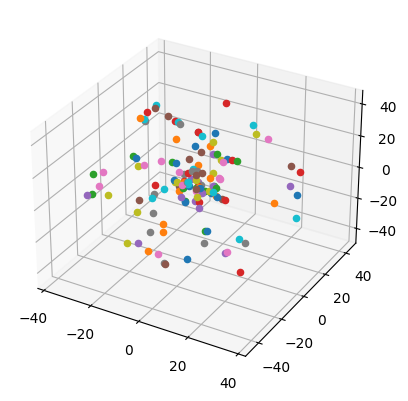

In [23]:
#Draw all transform_matrix in data in matplotlib
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for frame in data["frames"]:
    transform_matrix = np.array(frame["transform_matrix"])
    ax.scatter(transform_matrix[0, 3], transform_matrix[1, 3], transform_matrix[2, 3])
plt.show()    